
Start Time : 2023-09-19 00:27:35.313977


/Users/chrisfinlay/mambaforge/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model : fixed_orbit_rfi_compressed_fft_standard

Mean RFI Amp. : 109 Jy
Flag Rate :     92.21 %

Number of Antennas   :    8
Number of Time Steps :  450

Number of parameters per antenna/baseline
Gains :    2
RFI   :  121
AST   :  450

Number of parameters : 27166
Number of data points: 25200

End Time   : 2023-09-19 00:27:40.221102
Total Time : 0:00:04.907125

Reduced Chi^2 @ true: 0.993722420822468


Reduced Chi^2 @ init: 88.01111246673459


End Time  : 2023-09-19 00:27:53.442971
Plot Time : 0:00:13.221869

End Time  : 2023-09-19 00:28:01.413172
Plot Time : 0:00:07.970201

End Time  : 2023-09-19 00:28:01.413193
Plot Time : 0:00:00.000021


100%|███████████| 3000/3000 [00:24<00:00, 124.63it/s, init loss: 20777427.5789, avg. loss [2851-3000]: 66270.3484]



Reduced Chi^2 : 1.5796966532416254



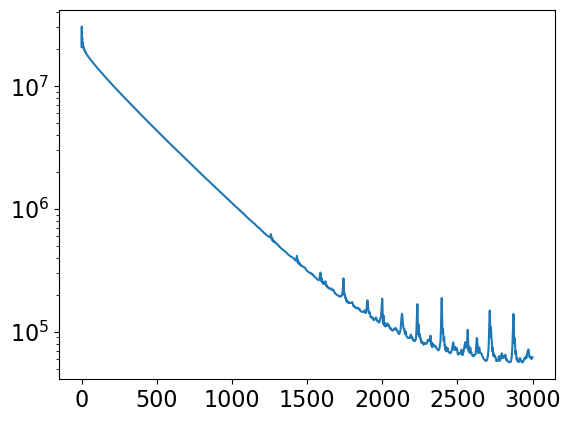


End Time  : 2023-09-19 00:28:36.551161
Plot Time : 0:00:35.137989

End Time  : 2023-09-19 00:28:36.551195
Plot Time : 0:00:00.000034

End Time  : 2023-09-19 00:28:36.551209
Infer Time : 0:00:00.000014


In [1]:
run tab_II_numpyro_gp_fft_standard.py

In [2]:
map_params = {k[:-9]: v for k, v in vi_results.params.items()}

In [3]:
tree_map(jnp.shape, map_params)

{'ast_k_i_base': (28, 450),
 'ast_k_r_base': (28, 450),
 'g_amp_induce_base': (8, 2),
 'g_phase_induce_base': (7, 2),
 'rfi_i_induce_base': (8, 121),
 'rfi_r_induce_base': (8, 121)}

In [4]:
from numpyro.infer.util import log_density

In [5]:
@jit
def U(params):
    return -1.0 * log_density(model, model_args=(), model_kwargs={"args": args, "v_obs": v_obs_ri}, params=params)[0]

In [6]:
from jax import grad

In [7]:
delU = jit(grad(U))

In [8]:
U(map_params) / vis_obs.size

Array(4.98729474, dtype=float64)

In [9]:
U(true_params_base) / vis_obs.size

Array(4.45371682, dtype=float64)

In [10]:
U(init_params_base) / vis_obs.size

Array(1649.0021888, dtype=float64)

In [11]:
tree_map(jnp.shape, delU(true_params_base))

{'ast_k_i_base': (28, 450),
 'ast_k_r_base': (28, 450),
 'g_amp_induce_base': (8, 2),
 'g_phase_induce_base': (7, 2),
 'rfi_i_induce_base': (8, 121),
 'rfi_r_induce_base': (8, 121)}

In [12]:
import optax

In [13]:
from tqdm import tqdm

In [14]:
q_i = init_params_base
q_i = true_params_base
q_i = map_params

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-1)
state = opt.init(q_i)

grads = delU(q_i)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new) / vis_obs.size

In [15]:
history = {
    **q_i,
    "U": jnp.array([U(q_i)/vis_obs.size])
    }
history = tree_map(lambda x, y: jnp.concatenate([x[None,:], y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

In [16]:
pbar = tqdm(range(200))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 3.964: 100%|█████████████████████████████████████████████████████| 200/200 [00:15<00:00, 13.00it/s]


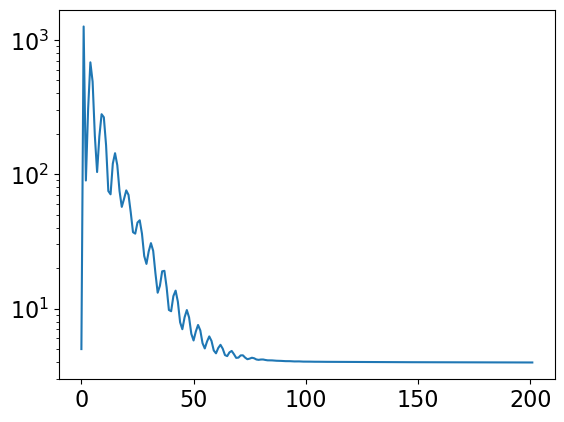

In [17]:
plt.semilogy(history['U'])

In [18]:
f_model = lambda params, args: fixed_orbit_rfi_compressed_fft_standard_model(params, args)[0]
model_flat = lambda params: f_model_flat(f_model, params, args)
key = random.PRNGKey(1)
# post_mean = true_params_base
# post_mean = {k[:-9]: v for k, v in vi_results.params.items()}
post_mean = q_new
samples = post_samples(
    model_flat,
    post_mean,
    flatten_obs(vis_obs),
    noise,
    num_samples=10,
    key=key,
    max_iter=max_cg_iter,
)

pred = Predictive(model, posterior_samples=samples)
fisher_pred = pred(random.PRNGKey(2), args=args)

In [19]:
def ast_vis_fn(params):
    obs_vis, (rfi_vis, ast_vis, gains) = fixed_orbit_rfi_compressed_fft_standard_model(params, args)
    return ast_vis

In [20]:
ast_vis_samples = vmap(ast_vis_fn, in_axes=(tree_map(lambda _: 0, q_new),))(samples)

In [21]:
obs_vis, (rfi_vis, ast_vis, gains) = fixed_orbit_rfi_compressed_fft_standard_model(q_new, args)

In [22]:
reduced_chi2(obs_vis, vis_obs[:, :, 0].T, noise)

Array(0.6818061, dtype=float64)

In [23]:
ast_vis_samples.shape

(20, 28, 450)

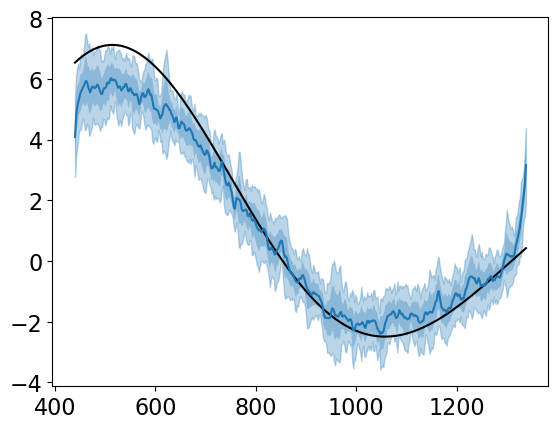

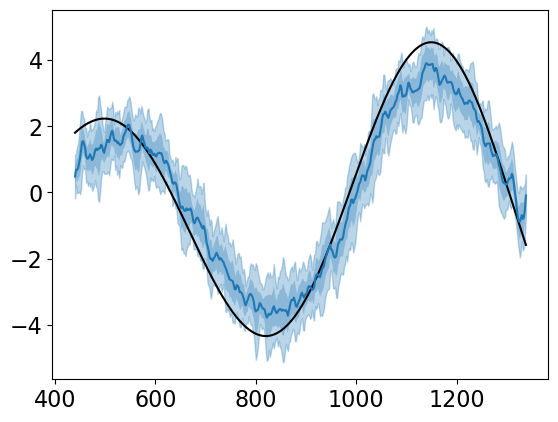

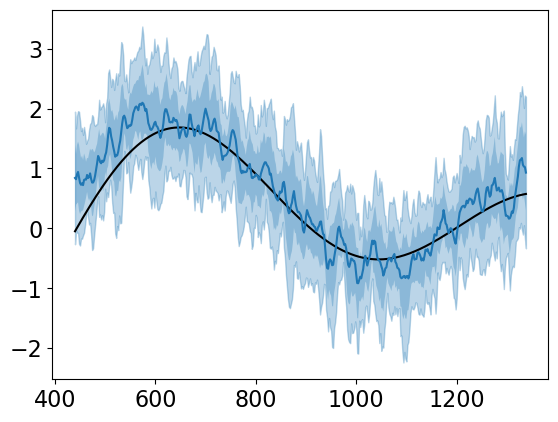

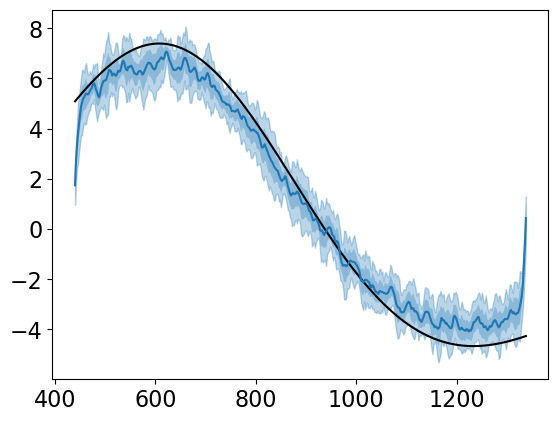

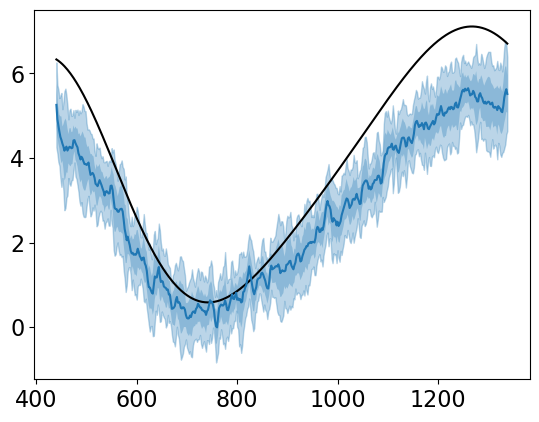

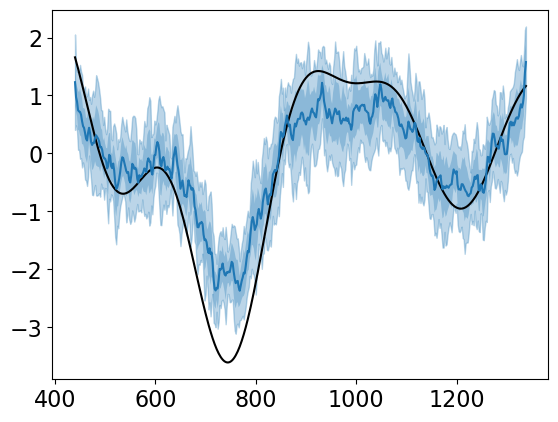

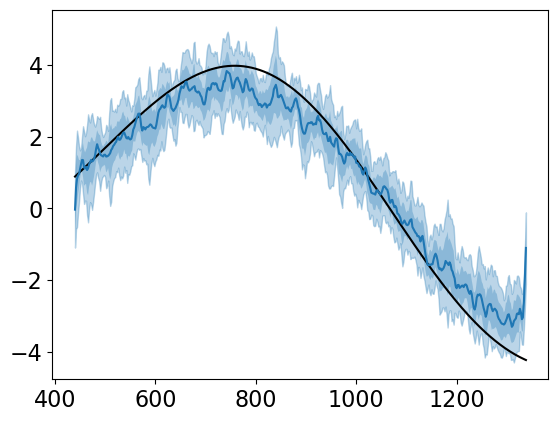

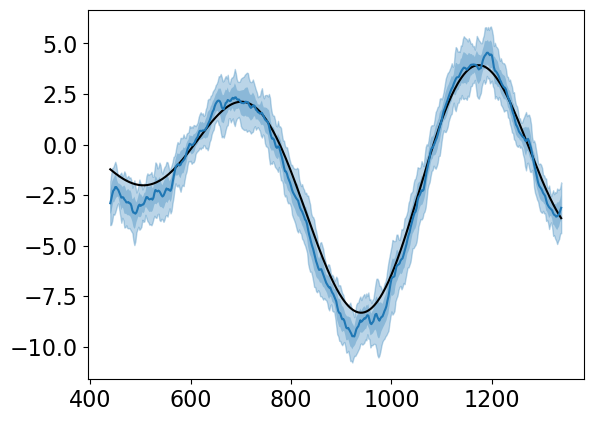

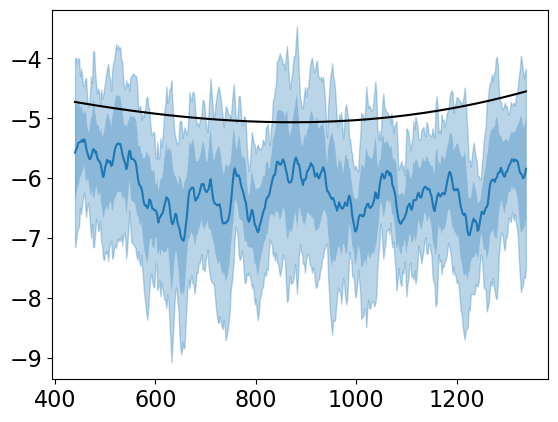

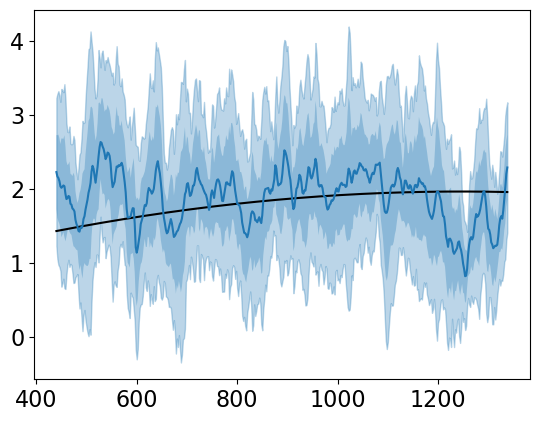

In [24]:
ast_vis_m = ast_vis_samples.mean(axis=0)
ast_vis_sr = ast_vis_samples.real.std(axis=0)
for b in range(min([10, N_bl])):
    plt.figure()
    plt.plot(times, vis_ast_true[:,b].real, 'k')
    plt.plot(times, ast_vis_m[b].real)
    plt.fill_between(times, 
                     ast_vis_m[b].real - ast_vis_sr[b], 
                     ast_vis_m[b].real + ast_vis_sr[b],
                     alpha=0.3)
    plt.fill_between(times, 
                     ast_vis_m[b].real - 2*ast_vis_sr[b], 
                     ast_vis_m[b].real + 2*ast_vis_sr[b],
                     alpha=0.3, color='tab:blue')

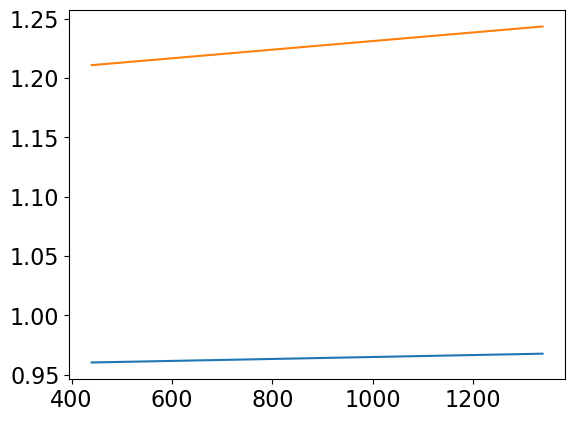

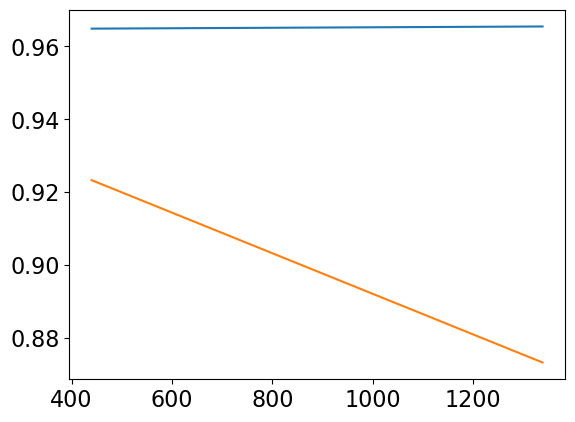

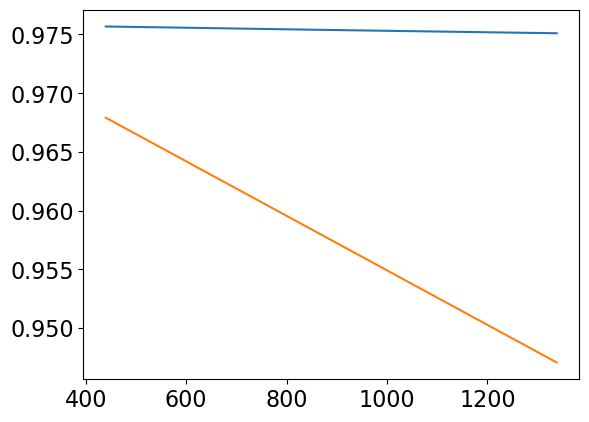

In [25]:
for b in range(3):
    plt.figure()
    plt.plot(times, jnp.abs(gains_true[:,b]))
    plt.plot(times, jnp.abs(gains[b]))

In [26]:
dtheta = tree_map(jnp.subtract, samples, post_mean)

In [27]:
@jit
def U_(params, dtheta):
    return vmap(U, in_axes=(tree_map(lambda _: 0, params),))(tree_map(jnp.add, dtheta, params)).mean()

In [28]:
@jit
def delU_(params, dtheta):
    param_samples = tree_map(jnp.add, params, dtheta)
    return tree_map(lambda x: x.mean(axis=0), vmap(delU)(param_samples))

In [29]:
tree_map(jnp.shape, delU_(post_mean, dtheta))

{'ast_k_i_base': (28, 450),
 'ast_k_r_base': (28, 450),
 'g_amp_induce_base': (8, 2),
 'g_phase_induce_base': (7, 2),
 'rfi_i_induce_base': (8, 121),
 'rfi_r_induce_base': (8, 121)}

In [30]:
q_i = init_params_base
q_i = true_params_base
q_i = map_params

opt = optax.adam(1e-1)
# opt = optax.adabelief(3e-1)
state = opt.init(q_i)

grads = delU_(q_i, dtheta)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U_(q_new, dtheta) / vis_obs.size

In [31]:
history = {
    **q_i,
    "U": jnp.array([U_(q_i, dtheta)/vis_obs.size])
    }
history = tree_map(lambda x, y: jnp.concatenate([x[None,:], y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

In [32]:
pbar = tqdm(range(300))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU_(q_new, dtheta)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U_(q_new, dtheta) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 26.146: 100%|████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.71it/s]


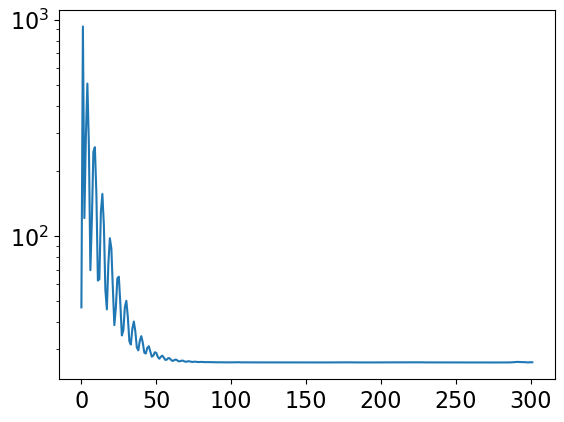

In [33]:
plt.semilogy(history['U'])

In [34]:
obs_vis, (rfi_vis, ast_vis, gains) = fixed_orbit_rfi_compressed_fft_standard_model(q_new, args)
reduced_chi2(obs_vis, vis_obs[:, :, 0].T, noise)

Array(13.10642006, dtype=float64)

In [35]:
obs_vis, (rfi_vis, ast_vis, gains) = fixed_orbit_rfi_compressed_fft_standard_model(map_params, args)
reduced_chi2(obs_vis, vis_obs[:, :, 0].T, noise)

Array(1.57969665, dtype=float64)

In [36]:
samples = tree_map(jnp.add, q_new, dtheta)
ast_vis_samples = vmap(ast_vis_fn, in_axes=(tree_map(lambda _: 0, q_new),))(samples)

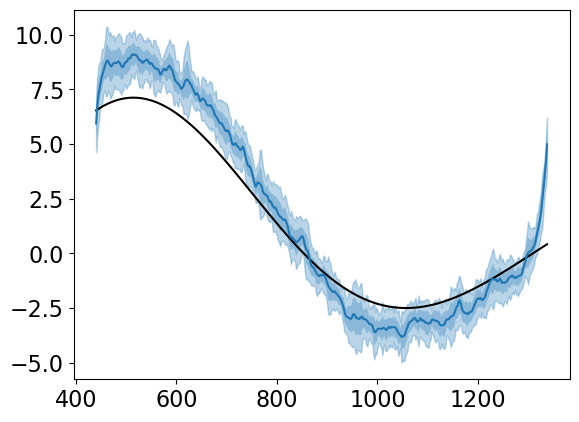

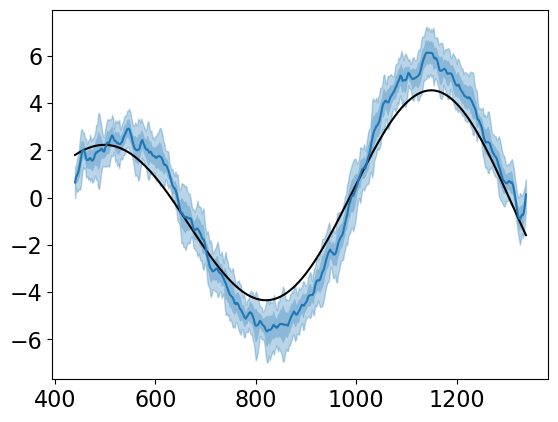

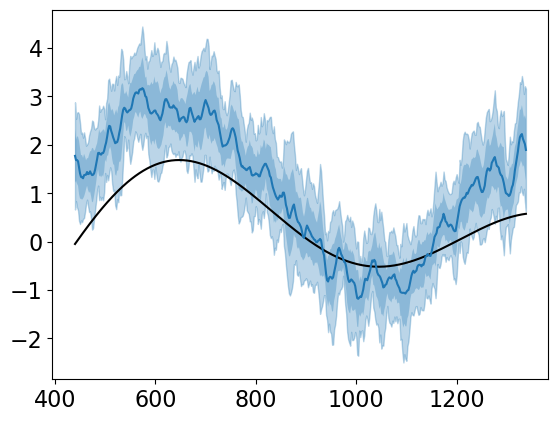

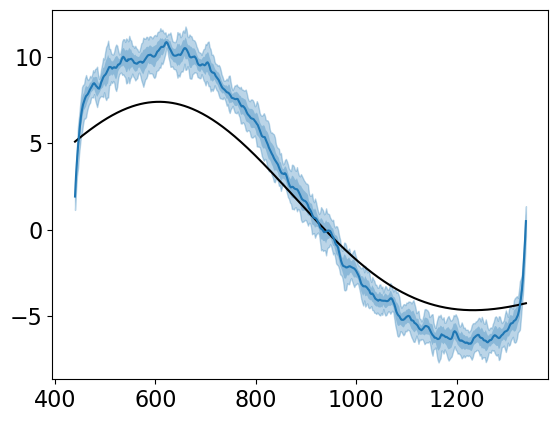

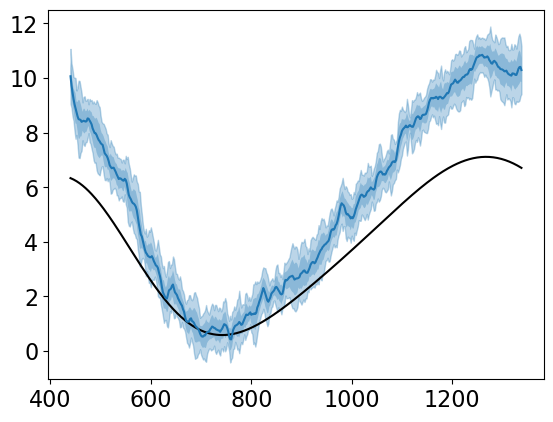

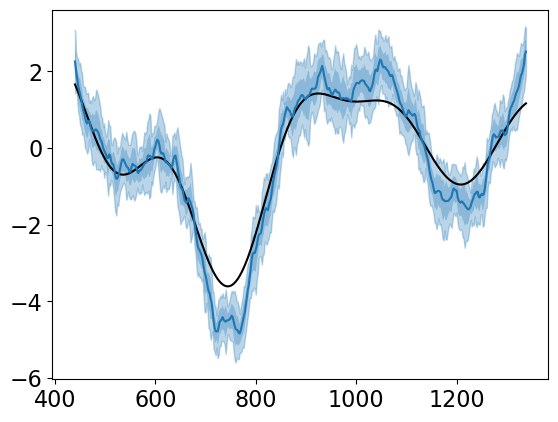

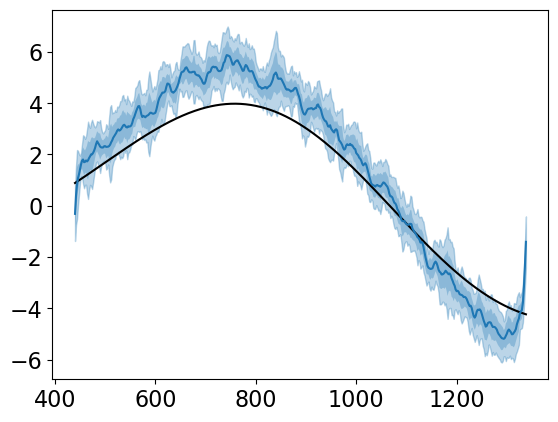

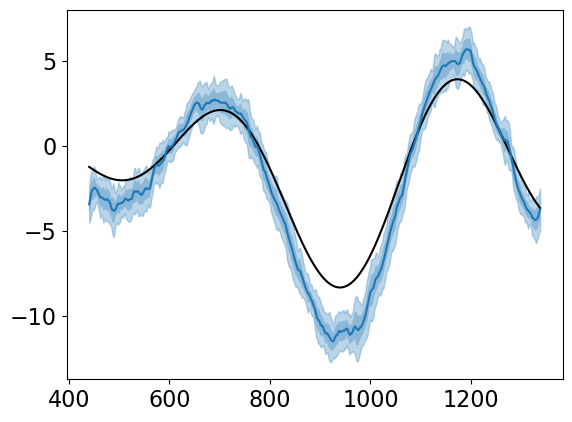

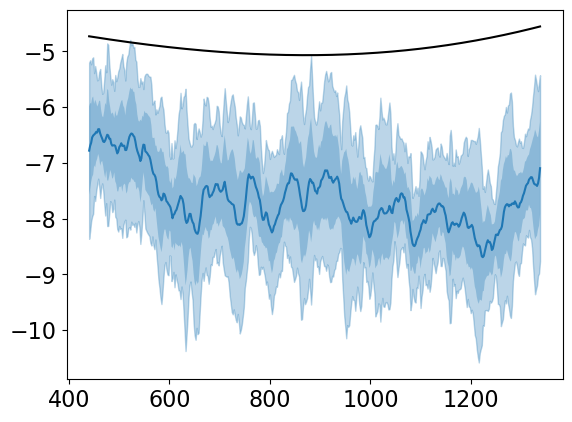

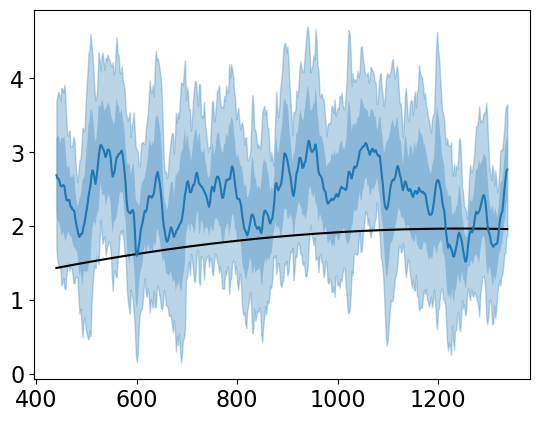

In [37]:
ast_vis_m = ast_vis_samples.mean(axis=0)
ast_vis_sr = ast_vis_samples.real.std(axis=0)
for b in range(min([10, N_bl])):
    plt.figure()
    plt.plot(times, vis_ast_true[:,b].real, 'k')
    plt.plot(times, ast_vis_m[b].real)
    plt.fill_between(times, 
                     ast_vis_m[b].real - ast_vis_sr[b], 
                     ast_vis_m[b].real + ast_vis_sr[b],
                     alpha=0.3)
    plt.fill_between(times, 
                     ast_vis_m[b].real - 2*ast_vis_sr[b], 
                     ast_vis_m[b].real + 2*ast_vis_sr[b],
                     alpha=0.3, color='tab:blue')

In [44]:
q_i = q_new
# q_i = true_values

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-2)
state = opt.init(q_i)

grads = delU(q_i)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new) / vis_obs.size

In [45]:
pbar = tqdm(range(100))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 5.078: 100%|█████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.44it/s]


In [30]:
q_i = q_new
# q_i = true_values

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-2)
state = opt.init(q_i)

grads = delU(q_i)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new) / vis_obs.size

In [31]:
pbar = tqdm(range(100))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 18.077: 100%|████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.41it/s]


In [49]:
q_i = q_new
# q_i = true_values

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-3)
state = opt.init(q_i)

grads = delU(q_i, params, a1, a2, bl)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new, params, a1, a2, bl) / vis_obs.size

In [50]:
pbar = tqdm(range(100))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new, params, a1, a2, bl)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new, params, a1, a2, bl) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 2.085: 100%|███████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]
